In [39]:
!nvidia-smi

Sun Sep  8 06:23:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              31W /  70W |  10537MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!pip install -U datasets

In [42]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [43]:
from datasets import load_metric
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/WikiHow/WikiHow4k.csv")
df.head()

,title,heading,paragraph
0,How to Get Your Horse to Trust You: 20 Helpful...,Rub all over your horse's body.,Doing this will let the horse know that he can...
1,How to Get Your Horse to Trust You: 20 Helpful...,Groom your horse.,"Like rubbing, grooming shows that you are frie..."
2,How to Get Your Horse to Trust You: 20 Helpful...,"Use other techniques to touch your horse, such...","Before massaging your horse, make sure that he..."
3,How to Get Your Horse to Trust You: 20 Helpful...,Pet your horse everyday to establish a closer ...,Like when you build a relationship with anothe...
4,How to Get Your Horse to Trust You: 20 Helpful...,Place a bridle on your horse.,The horse's bridle will need to comfortably pl...


In [44]:
print(df.shape)
df=df.dropna()
print(df.shape)

(61008, 3)
(60330, 3)


In [45]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(60330, 3)
(49421, 3)


In [46]:
df['length']=df.paragraph.map(lambda x: len(x.split(" ")))

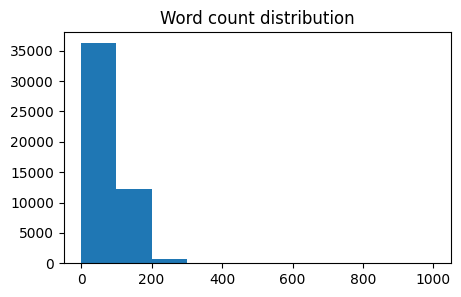

In [47]:
numOfWords=df.length
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(5,3))
plt.hist(numOfWords.to_numpy(),bins=[0.50,100,200,300,500,1000])
plt.title("Word count distribution")
plt.show()


In [48]:
tempDf=df[df.length<=200]
tempDf.shape

(48536, 4)

In [49]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained("allenai/led-base-16384")

loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [50]:
max_input_length = 1024
max_output_length = 64
batch_size = 16

def process_data_to_model_inputs(batch):
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"])*[
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


In [51]:
import numpy as np
train, validate,test = np.split(tempDf.sample(frac=1,random_state=42),[int(.6*len(df)),int(.7*len(df))])
print(train.shape)
print(validate.shape)
print(test.shape)

(29652, 4)
(4942, 4)
(13942, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [52]:
validate=validate[:20]

In [53]:
validate.shape

(20, 4)

In [54]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

In [55]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"]
)

Map:   0%|          | 0/29652 [00:00<?, ? examples/s]

In [56]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"]
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [57]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)

In [58]:
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokent=True)
    labels_ids [labels_ids == -100]=  tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_takens=True)

    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"]
    )["rouge2"].mid
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4)
    }

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()


training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)


loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [59]:
trainer= Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [26]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 29652
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 4630
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two vari

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.117400,1.720761,0.851100,0.856800,0.853500
20,2.119000,1.641252,0.846500,0.851300,0.848700
30,2.103500,1.602278,0.841900,0.850700,0.846300
40,2.109400,1.633907,0.854100,0.862200,0.858000
50,1.992500,1.603565,0.861600,0.864500,0.863100
60,2.052000,1.618533,0.839600,0.845100,0.842400
70,2.097900,1.628273,0.850500,0.857200,0.853600
80,2.014700,1.602072,0.848300,0.856500,0.852100
90,1.956300,1.591976,0.850000,0.855600,0.852500
100,1.955800,1.641683,0.849600,0.856100,0.852700


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cp

KeyboardInterrupt: 

In [60]:
import pandas as pd
sample_paragraph ="The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management."
data=[sample_paragraph]
df=pd.DataFrame(data,columns=['paragraph'])
df['paragraph'][0]
from datasets import Dataset
df_test=Dataset.from_pandas(df)
df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [74]:
from datasets import load_metric
import torch
from transformers import LEDTokenizer, LEDForConditionalGeneration
from sklearn.feature_extraction.text import CountVectorizer

# Load tokenizer and model for LED
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-100")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-100").to("cuda").half()

# Load tokenizer and model for summarization
from transformers import BartTokenizer, BartForConditionalGeneration
summarizer_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
summarizer_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to("cuda").half()

def summarize_paragraph(paragraph):
    inputs = summarizer_tokenizer(paragraph, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = summarizer_model.generate(inputs['input_ids'].to("cuda"), max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def generate_tags(paragraph):
    vectorizer = CountVectorizer(stop_words='english', max_features=5)
    X = vectorizer.fit_transform([paragraph])
    features = vectorizer.get_feature_names_out()
    return features

def generate_answer(batch):
    inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
    input_ids = inputs_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")
    global_attention_mask = torch.zeros_like(attention_mask).to("cuda")

    predicted_heading_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
    batch["generated_heading"] = tokenizer.batch_decode(predicted_heading_ids, skip_special_tokens=True)

    #Generating summary
    summaries = [summarize_paragraph(text) for text in batch["paragraph"]]
    batch["generated_summary"] = summaries

    #Generating tags
    tags = [generate_tags(text) for text in batch["paragraph"]]
    batch["generated_tags"] = tags

    return batch

data = ["The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management."]
df_test = pd.DataFrame(data, columns=['paragraph'])
df_test = Dataset.from_pandas(df_test)

result = df_test.map(generate_answer, batched=True, batch_size=2)




Didn't find file /content/checkpoint-100/added_tokens.json. We won't load it.
loading file /content/checkpoint-100/vocab.json
loading file /content/checkpoint-100/merges.txt
loading file None
loading file /content/checkpoint-100/special_tokens_map.json
loading file /content/checkpoint-100/tokenizer_config.json
loading configuration file /content/checkpoint-100/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "e

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [76]:
print("Generated Headings:", result["generated_heading"])
print("Generated Summaries:", result["generated_summary"])
print("Generated Tags:", result["generated_tags"])


Generated Headings: ['Have a leader to guide you.']
Generated Summaries: ['The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people?']
Generated Tags: [['apple', 'culture', 'decisions', 'having', 'weeks']]
